## **SHAP 임계값 설정**

## 이상 원인 분석 (SHAP)

- 각 피처(feature)가 예측 결과에 어떤 영향을 미쳤는지 정량적으로 보여주는 도구
- 예측값이 기준값(=평균 예측값)에서 얼마나 벗어났는지, 그리고 그 벗어나는 데 각 피처가 얼마만큼 기여했는지 알수있음

In [ ]:
# 예측값
y_pred = best_model.predict(X_test)

# 오차 비율 계산
error_ratio = np.abs((y_test - y_pred) / y_test)

# 이상값 조건: 예측 오차가 10% 이상
anomalies = error_ratio > 0.1

# 이상값 중 첫 번째 샘플 인덱스 (테스트용)
anomaly_index = np.where(anomalies)[0][0]

# 이상값 샘플 추출
x_anomaly = X_test.iloc[[anomaly_index]]


- SHAP 분석 예시

In [ ]:
# SHAP 분석 예시 시각화 및 시뮬레이션용 이상값 샘플
x_anomaly

,PT_jo_V_1,PT_jo_A_Main_1,PT_jo_TP
156,285.0,32.0,34.0


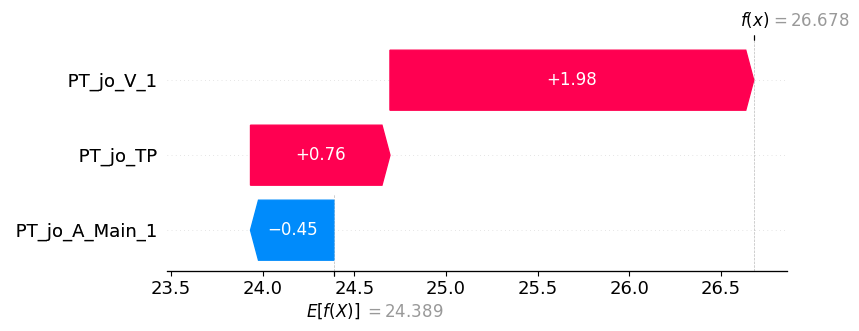

In [ ]:
import shap

# explainer 정의
explainer = shap.TreeExplainer(best_model, data=X_train)

# SHAP 값 계산 (단일 샘플)
shap_values = explainer.shap_values(x_anomaly)

# waterfall plot (예상값, SHAP 값, 원본 값)
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,      # 첫 번째 expected_value만 사용
    shap_values[0],                   # 첫 번째 샘플에 대한 SHAP 값
    x_anomaly.iloc[0]                 # 첫 번째 샘플의 입력값
)

- 두께의 예측 오차가 10%을 넘었을때 각 feature의 기여도를 나타냄
- 해당 샘플의 이상은 전압의 과다(+1.98)가 가장 큰 원인

## 이상치 샘플 SHAP 합 분포 시각화 및 임계값 설정

- 예측 오차가 10% 이상인 이상치 샘플들에 대해서만 SHAP 합을 계산하고, 그 분포를 시각화합니다. 이 분포를 보고 SHAP 기여도가 낮은 이상치(일반 기계 문제로 분류)와 SHAP 기여도가 높은 이상치(세부 원인 분류)를 나눌 임계값(`shap_threshold`)을 결정합니다.

- 히스토그램에서 SHAP 합이 집중된 구간과 꼬리 부분을 확인하고, 두 그룹을 구분하기에 적절한 값을 임계값으로 선택할 수 있습니다.

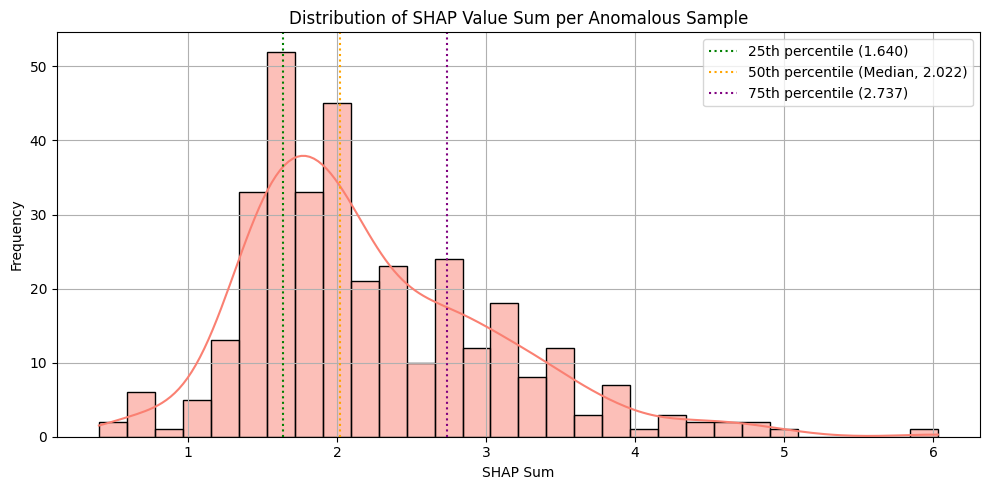

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화
plt.figure(figsize=(10, 5))
sns.histplot(shap_sums_anomaly, bins=30, kde=True, color='salmon')

# 분위수(예: 25%, 50%) 표시 (참고용)
quantiles = np.percentile(shap_sums_anomaly, [25, 50, 75])
plt.axvline(quantiles[0], color='green', linestyle=':', label=f'25th percentile ({quantiles[0]:.3f})')
plt.axvline(quantiles[1], color='orange', linestyle=':', label=f'50th percentile (Median, {quantiles[1]:.3f})')
plt.axvline(quantiles[2], color='purple', linestyle=':', label=f'75th percentile ({quantiles[2]:.3f})')

plt.title('Distribution of SHAP Value Sum per Anomalous Sample')
plt.xlabel('SHAP Sum')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- 분위수와 시각화 자료를 참고하여 모델에 적용할 SHAP 임계값을 중앙값(Median) 값으로 설정

## 이상치 샘플들로 출력 Test

In [ ]:
# 결론 : 임계값을 2.0로 설정
shap_threshold = 2.0 # 이전 셀에서 정의된 shap_threshold 사용

# logs 기록
logs = []

# 이상치 샘플에 대해 계산된 SHAP 값과 합 사용
shap_array = shap_values_anomaly.values
feature_names = list(shap_values_anomaly.feature_names)
shap_sums = shap_sums_anomaly

# X_error_samples 대신 X_anomaly 사용
X_error_samples = X_anomaly
y_error_samples = y_anomaly # y_anomaly 사용

for i in range(len(X_error_samples)):
    row = X_error_samples.iloc[i]
    shap_row = shap_array[i]

    # SHAP 값의 절대값으로 각 특성의 기여도 크기 계산
    shap_dict = {f: abs(shap_row[feature_names.index(f)]) for f in ['PT_jo_V_1', 'PT_jo_A_Main_1', 'PT_jo_TP']}
    # SHAP 원본 값 (부호 포함) 저장하여 원인 판단에 사용
    shap_raw_dict = {f: shap_row[feature_names.index(f)] for f in ['PT_jo_V_1', 'PT_jo_A_Main_1', 'PT_jo_TP']}
    shap_sum = shap_sums[i] # 미리 계산된 SHAP 합 사용

    # 가장 큰 영향 요소
    main_cause = max(shap_dict, key=shap_dict.get)
    main_shap_value = shap_raw_dict[main_cause] # 원본 SHAP 값 사용

    # SHAP 합 임계값을 기준으로 세부 원인 코드 부여
    if shap_sum < shap_threshold:
        issue = "PAINT-EQUIP-MACHINE" # SHAP 기여도가 낮으면 일반 기계 문제로 판단
    else:
        if main_cause == 'PT_jo_V_1':
            issue = "PAINT-EQUIP-VOLTAGE-HIGH" if main_shap_value > 0 else "PAINT-EQUIP-VOLTAGE-LOW"
        elif main_cause == 'PT_jo_A_Main_1':
            issue = "PAINT-EQUIP-CURRENT-HIGH" if main_shap_value > 0 else "PAINT-EQUIP-CURRENT-LOW"
        elif main_cause == 'PT_jo_TP':
            issue = "PAINT-EQUIP-TEMPER-HIGH" if main_shap_value > 0 else "PAINT-EQUIP-TEMPER-LOW"
        else:
            issue = "PAINT-EQUIP-UNKNOWN" # 예상치 못한 경우

    logs.append({
        'Index': error_indices[i], # 원본 인덱스 사용
        'Voltage': row['PT_jo_V_1'],
        'Current': row['PT_jo_A_Main_1'],
        'Temp': row['PT_jo_TP'],
        'Actual_Thick': y_error_samples.iloc[i], # 실제 두께
        'Predicted_Thick': best_model.predict(pd.DataFrame([row]))[0], # 예측 두께 계산
        'SHAP_Sum': shap_sum, # SHAP 합 추가 (확인용)
        'Main_SHAP_Value': main_shap_value, # 주 원인 SHAP 값 추가 (확인용)
        'Issue_Code': issue
    })

log_df = pd.DataFrame(logs)
print(log_df)

     Index  Voltage  Current  Temp  Actual_Thick  Predicted_Thick  SHAP_Sum  \
0      156    285.0     32.0  34.0          21.5        26.678358  3.198359   
1     2413    279.0    116.0  33.0          23.7        26.348954  1.960324   
2    15316    289.0     45.0  34.0          22.7        25.179703  2.050788   
3      123    241.0     21.0  34.0          19.1        23.139360  1.304499   
4    11563    279.0    118.0  34.0          23.1        25.795311  1.550199   
..     ...      ...      ...   ...           ...              ...       ...   
335   2456    279.0     99.0  33.0          31.4        26.426174  2.037544   
336  13651    207.0     20.0  33.0          18.4        20.503747  3.884883   
337    223    283.0     22.0  34.0          19.9        22.207054  2.181576   
338   9743    278.0    162.0  33.0          29.4        26.336007  1.947377   
339    622    289.0    108.0  34.0          21.8        25.537755  1.856747   

     Main_SHAP_Value                Issue_Code  
0 